Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of missing values before cleaning:
ALand : 70
Mean : 315
Median : 315
Stdev : 315
Households : 315

Number of missing values after cleaning:
ALand : 0
Mean : 0
Median : 0
Stdev : 0
Households : 0


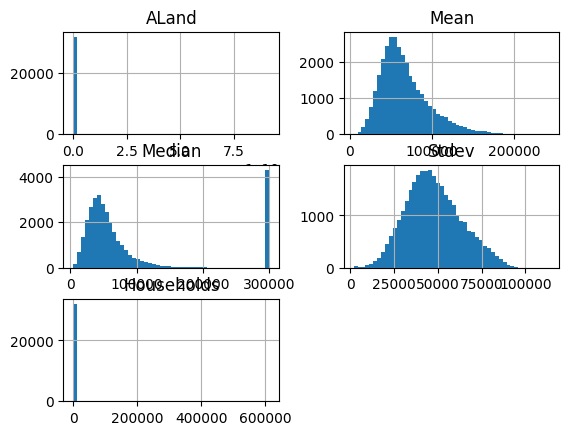

In [111]:
# Mari Sisco and Tim Lefebvre

# Importing necessary libraries for clustering and plotting
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from google.colab import drive

# Loading the csv file from google drive to a pandas Dataframe
drive.mount('/content/drive')

dfIncome = pd.read_csv("/content/drive/My Drive/income_utf8.csv")
dfIncome.describe()


# Choosing columns that will be used in analysis
dfIncomeReduced = dfIncome[['ALand','Mean', 'Median', 'Stdev', 'Households']]

# Checking number of missing values
def checkmissing(df):
  for column in df.columns:
    countmissing = 0
    for value in df[column]:
      if value==0:
        countmissing += 1
    print(column , ":" , countmissing)

# Before cleaning, there are a certain number of missing values
print("Number of missing values before cleaning:")
checkmissing(dfIncomeReduced)
# Removing all values where it equals 0
dfIncomeReduced = dfIncomeReduced.loc[(dfIncomeReduced!=0).all(axis=1)]
# After cleaning, no missing values left
print("\nNumber of missing values after cleaning:")
checkmissing(dfIncomeReduced)

# Creating histograms of each column in order to see the skewness of each
dfIncomeReduced.hist(bins=50)

# Copy Of Original
dfIncomeReducedCopy = dfIncomeReduced.copy()

In [113]:
# function used to standardize Dataframe
def standardize_data(df, columns):
    # scaler: initializing StandardScaler
    scaler = StandardScaler()
    # Apply scaler to the specified columns
    df[columns] = scaler.fit_transform(df[columns])

    return df

# Standardizing columns
dfIncomeStandardized = standardize_data(dfIncomeReduced, columns = ['ALand','Mean', 'Median', 'Stdev', 'Households'])

# Weighting the importance of each variable
weights = {
    'ALand': 1,
    'Mean': 30,
    'Median': 3,
    'Stdev': 6,
    'Households': 1
}

# Appling weights
for col in dfIncomeStandardized.columns:
    dfIncomeStandardized[col] *= weights[col]

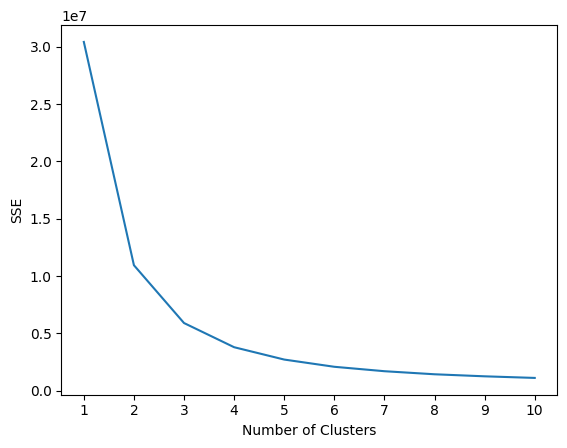

In [114]:
# Finding best number of clusters

# Code obtained from Statology.org

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
KMeansdf = dfIncomeStandardized[['Mean','Median','Stdev']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(KMeansdf)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [115]:
from sklearn.metrics import silhouette_score

# Perfoming kmeans clustering and evaluating success through the Silhouette Score
def kmeans_clustering(df, dfOriginal, n_clusters):
  # kmeans clustering
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(df)
  labels = kmeans.labels_
  df.loc[:, 'Cluster'] = labels
  dfOriginal.loc[:, 'Cluster'] = labels

  # Obtaining Silhouette score
  silhouette_avg = silhouette_score(df, labels)
  print("Validity of clustering, Silhouette score:", silhouette_avg)

  df = dfOriginal
  # Returns Dataframe with clusters
  return df

clustered_income_df = kmeans_clustering(KMeansdf, dfIncomeReducedCopy, 3)
clustered_income_df.to_csv('clustered_income_data.csv', index=False)



<ipython-input-115-95f2075c6796>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Cluster'] = labels


Validity of clustering, Silhouette score: 0.516779684356481


  Cluster         ALand                                    Mean            \
                   mean     median           std           mean    median   
0       0  1.414166e+08  4404670.0  1.658260e+09   44968.623272   46579.0   
1       1  1.186226e+08  6135563.5  8.557271e+08   77506.703598   75712.0   
2       2  1.959726e+07  4688104.0  1.103781e+08  126148.823086  120394.0   

                        Median                                 Stdev           \
            std           mean    median           std          mean   median   
0  10811.131980   50016.861975   36733.5  61719.920782  36549.104568  36927.5   
1  11281.329045  103595.106759   66579.0  88333.626876  54641.580447  54202.0   
2  20731.494886  179052.669259  127547.0  90454.205004  71813.482139  72289.0   

                 Households                           
            std        mean      median          std  
0   9945.513597  617.272615  373.330784  2122.604106  
1   9903.122644  625.202862  323.612230  59

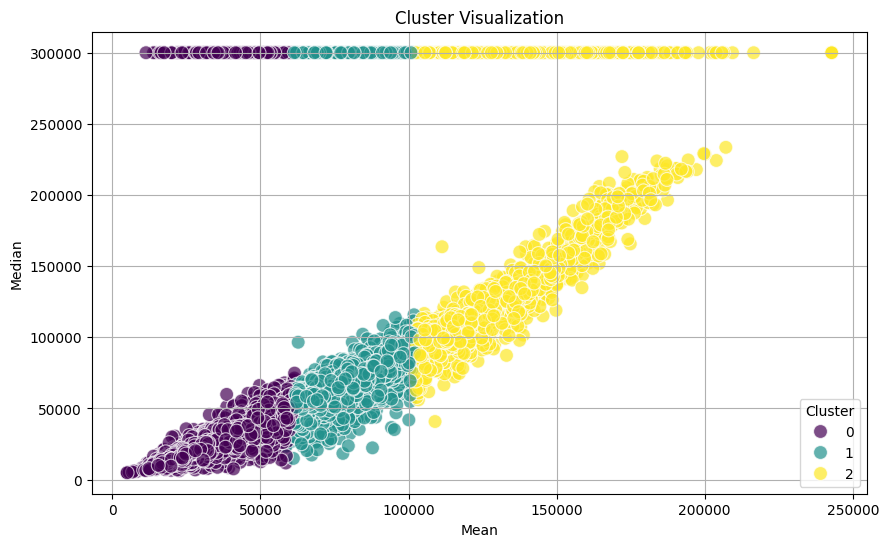

In [116]:
# Group the DataFrame by the 'Cluster' column
cluster_stats = clustered_income_df.groupby('Cluster').agg(['mean', 'median', 'std']).reset_index()

# Display the descriptive statistics for each cluster
print(cluster_stats)

import seaborn as sns

# Visualize clusters in Mean vs Median Scenario
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_income_df, x='Mean', y='Median', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization')
plt.xlabel('Mean')
plt.ylabel('Median')
plt.grid(True)
plt.savefig('cluster_visualization.png')
plt.show()